# INITIAL IMPORTS AND SET UP

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf 
import os 
import numpy as np  
from google.colab import drive

SEED= 10558133
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PREPARATION 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#in this block we apply data augmentation if set to true otherwise we only perform rescaling for adding some regularitazion 

apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(             
    rescale=1./255,
    rotation_range=.05,
    shear_range=.05,
    zoom_range=.05,
    cval=.05,
    horizontal_flip=True,
    vertical_flip=True)
  
else:
  train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)


In [ ]:

#now I need to get the test images and associate them to the label contained in the json file creating a pandas dataframe 
import pandas as pd
import json
import sklearn

json_path=os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset')

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df) #here we shuffle the dataframe from which we are gonna get training and validation datasets 

#retrieve validation dataframe as 10% of original dataset 

training_df= train_df_shuffled[614:]
validation_df= train_df_shuffled[:614]

print(validation_df,training_df)

       filename class
756   11720.jpg     0
4390  15150.jpg     2
1413  12393.jpg     0
3671  13884.jpg     1
3391  14492.jpg     1
...         ...   ...
3913  16351.jpg     2
3078  15832.jpg     1
5189  11717.jpg     2
5178  18200.jpg     2
2720  14859.jpg     1

[614 rows x 2 columns]        filename class
5139  10237.jpg     2
808   12236.jpg     0
4531  14084.jpg     2
3371  15253.jpg     1
1621  16848.jpg     0
...         ...   ...
266   13645.jpg     0
1176  11456.jpg     0
116   16371.jpg     0
3359  10232.jpg     1
3984  18115.jpg     2

[5000 rows x 2 columns]


In [ ]:
#Let's create the generators 

directory_training =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','training')

 
bs = 10
 
train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
 
shuffle=True,
target_size=(256,256),
class_mode="categorical",
)
 
valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(256,256),
class_mode="categorical",
)



Found 5000 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


In [ ]:
num_classes=3
img_h=256
img_w=256

#lets get the datasets and set the repeat 

train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


# IMAGE PLOTTING

[]

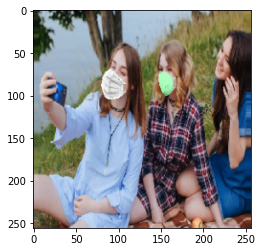

In [ ]:
#some plotting of the training dataset to get insights on the data 
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)
img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

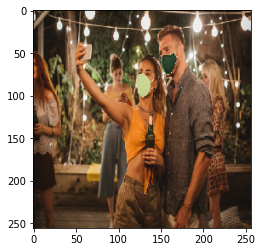

In [ ]:
#some plotting of the validation dataset to get insights on the data 
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

# MODEL DEFINITION AND TRAINING

In [ ]:
#here we build our model and import some modules 

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from keras.applications import *
from tensorflow.keras.optimizers import Adam

base_model = Xception(include_top = False , input_shape = (img_h,img_w,num_classes)) #we are going to exploit Xception for transfer learning 

#we are going to retrain the whole model 

for layer in base_model.layers:
    layer.trainable = True

# Add layers at the end
model = base_model.output
model = Flatten()(model)

model = Dense(512, kernel_initializer='he_uniform')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)

model = Dense(128, kernel_initializer='he_uniform')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)

model = Dense(52, kernel_initializer='he_uniform')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)

model = Dense(16, kernel_initializer='he_uniform')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)

output = Dense(3, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:

loss= tf.keras.losses.CategoricalCrossentropy() #we pick categorical crossentropy for our problem as loss function

lr= 1e-4 #learning rate 

optimizer=tf.keras.optimizers.Adam(learning_rate=lr) #optimizer Adam 

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

In [ ]:
#here we fit our model and add some callbacks 


callbacks=[]

#early stopping to deal with overfitting 
es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True) 
callbacks.append(es_callback)
    

#Reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,  
                              verbose=1, mode='auto')
callbacks.append(reduce_lr)

model.fit(x=train_dataset, 
          epochs=10,  #max number of epoch 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

Epoch 1/10
500/500 [==============================] - 220s 440ms/step - loss: 0.0427 - accuracy: 0.9904 - val_loss: 0.3767 - val_accuracy: 0.9104
Epoch 2/10
500/500 [==============================] - 218s 437ms/step - loss: 0.0532 - accuracy: 0.9876 - val_loss: 0.2980 - val_accuracy: 0.9235
Epoch 3/10
500/500 [==============================] - 220s 440ms/step - loss: 0.0518 - accuracy: 0.9868 - val_loss: 0.3607 - val_accuracy: 0.9235
Epoch 4/10
500/500 [==============================] - 219s 437ms/step - loss: 0.0627 - accuracy: 0.9846 - val_loss: 0.4032 - val_accuracy: 0.9039
Epoch 5/10
500/500 [==============================] - 219s 438ms/step - loss: 0.0390 - accuracy: 0.9908 - val_loss: 0.5840 - val_accuracy: 0.8795
Epoch 6/10
500/500 [==============================] - 222s 444ms/step - loss: 0.0488 - accuracy: 0.9876 - val_loss: 0.3992 - val_accuracy: 0.9153
Epoch 7/10
500/500 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9880
Epoch 00007: ReduceLROnPlate

# TESTING AND CSV EXPORT 

In [ ]:
test_dir =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()


predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, '/content/drive/My Drive/AN2DL_HW_1')

Found 450 images belonging to 1 classes.
450/450 [==============================] - 5s 11ms/step
